# ARMA(p,q)($q\geq1$)のモデルで作成されたinnovationを推定できるかどうかを確かめる。

## 動機
そもそも$q=0$のモデルを仮定してinnovationを推定し変化点検知をすると言うのでは、ただの予測誤差に夜変化点検知と何にも変わらない。

やはり最終的にはinnovation自体も複雑に絡み合って$X_t$が生成される、そう言うモデルのinnovationを推定したい。

それが可能かどうかを確かめる。

## 実験概要
### まずは$ARMA(p,q\geq1)$モデルで確かめる。
- $ARMA(p,q\geq1)$に従うモデルを作成
- このモデルから作成された人工データから正確にinnovationが推定できるかどうか
- 推定するにはどのくらいの$\hat p$の値が必要なのか

評価はinnovationの推定値と正解との平均二乗誤差とする。

### 非線形でinnovation系列もバラバラに組み合わせたモデルを作成して確かめる。

## 実験詳細
ここで確認しながらつめる。

In [1]:
import argparse
import os
path = os.getcwd()
path=path[:path.find('estimate-innovation')+20]
# No = (os.path.basename(__file__))[-4]
No = "0" # notebook用
# print('実験No.'+No)
import warnings
warnings.simplefilter('ignore')# 警告を非表示
import numpy as np
np.set_printoptions(precision=4, floatmode='fixed', suppress=True)
import matplotlib.pyplot as plt
from scipy import stats
import math
import sys
sys.path.append(path)
import random
import time
import statsmodels.api as sm
from scipy.stats import norm
import japanize_matplotlib
from scipy.stats import gaussian_kde

import torchvision.transforms as transforms
from torchvision.utils import save_image

import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.autograd import Variable
# 人工データを生成してくれる機械が置いてあるところ
import tsModel
# 前処理用の関数の置き場
import my_preprocess
# 学習用のニューラルネットが置いてあるところ
import models
# p-Wasserstein距離の関数
import Wasserstein

### ARMAモデルの作成と可視化

In [273]:
phi_a = [1.0, -0.5, 0.7, -0.4]
phi_b = [1.0, -0.7]
p_ast = len(phi_a)
q_ast = len(phi_b)
dataSeed=5
N = 1000
data = tsModel.ARIMA(a=phi_a, b=phi_b, N=N, random_seed=dataSeed, randomness='normal')
inno = tsModel.ARIMA(a=phi_a, b=phi_b, N=N, random_seed=dataSeed, randomness='normal', return_innovation=True)

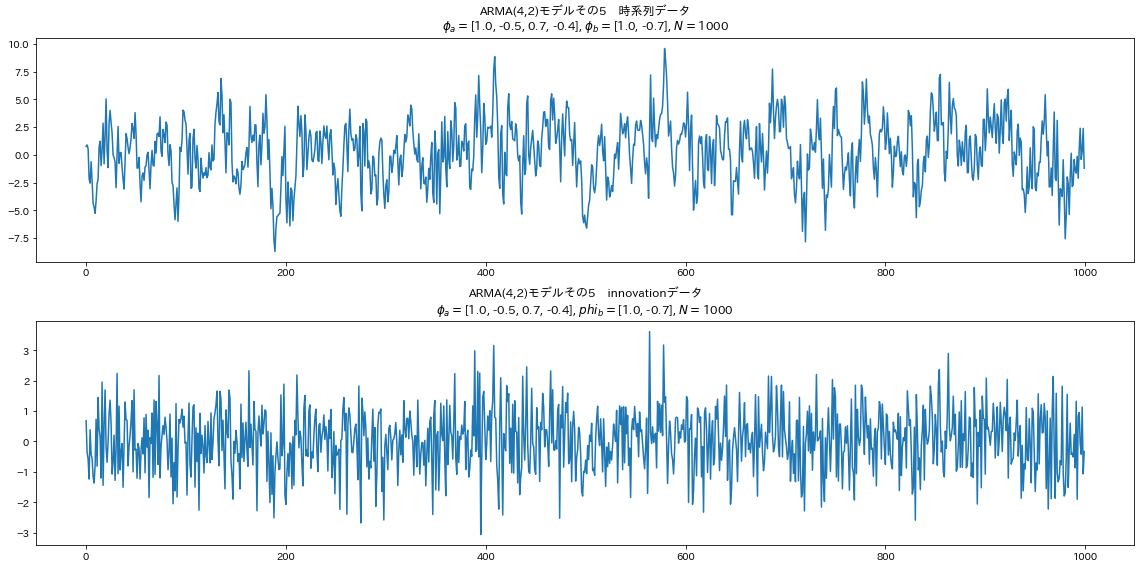

In [274]:
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.plot(data, label ='data')
ax2.plot(inno, label ='innovation')
ax1.title.set_text('ARMA({0},{1})モデルその{2}　時系列データ'.format(p_ast,q_ast,dataSeed) + '\n$\phi_a=${0}, $\phi_b=${1}, $N=${2}'.format(phi_a,phi_b,N))
ax2.title.set_text('ARMA({0},{1})モデルその{2}　innovationデータ'.format(p_ast,q_ast,dataSeed) + '\n$\phi_a=${0}, $phi_b=${1}, $N=${2}'.format(phi_a,phi_b,N))
plt.tight_layout()
plt.savefig('./images/ARMA{0}-{1}sample.png'.format(p_ast,q_ast))


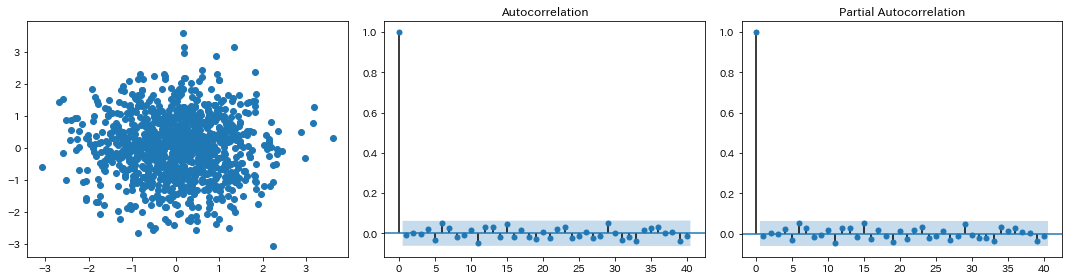

In [275]:
# 一時刻差のラグプロットと自己相関係数(innovationの独立性の確認)
fig = plt.figure(figsize=(15,4))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)
ax1.scatter(inno[:-1], inno[1:])
sm.graphics.tsa.plot_acf(inno, ax=ax2, lags=40)
sm.graphics.tsa.plot_pacf(inno, ax=ax3, lags=40)
plt.tight_layout()

発散もしてないし、innoも独立なので、
とりあえずこのモデルで良さそう。

### 対象実験として、$AR(\hat p)$を仮定してモデリングをした、その残渣系列のMSEをみる

In [276]:
from statsmodels.tsa.ar_model import ar_select_order

In [277]:
# ARモデルにおけるの次数をaicで推定
mod = ar_select_order(data, maxlag=13)
mod.ar_lags

array([1, 2, 3, 4, 5, 6])

In [278]:
# ARモデルの係数を学習
from statsmodels.tsa.ar_model import AutoReg
res = AutoReg(data, lags = mod.ar_lags).fit()

In [279]:
res.params

array([ 0.0651,  1.1834, -1.0195,  1.2137, -0.8426,  0.4025, -0.1591])

2.175566463313058


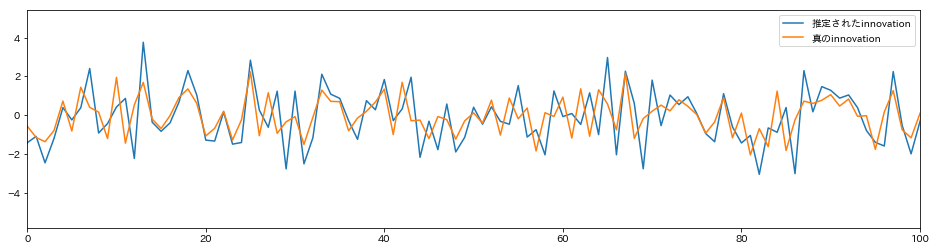

In [280]:
# 訓練データにおける予測誤差と真のinnovationの値を比較
plt.figure(figsize=(16,4))
plt.plot(data[6:]-res.predict(), label='推定されたinnovation')
plt.plot(inno[6:], label='真のinnovation')
plt.legend()
plt.xlim([0,100])
print(((data[6:]-res.predict())**2).sum()/len(data[6:]))

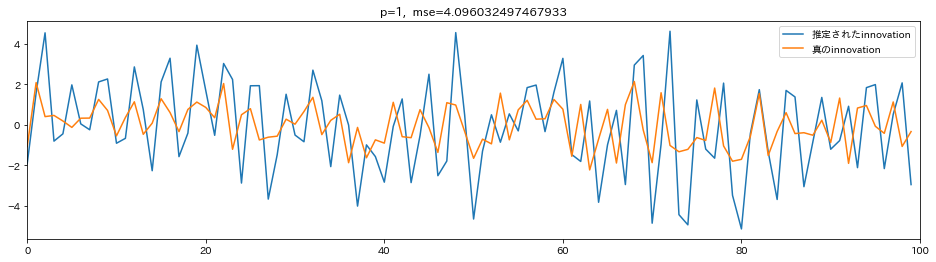

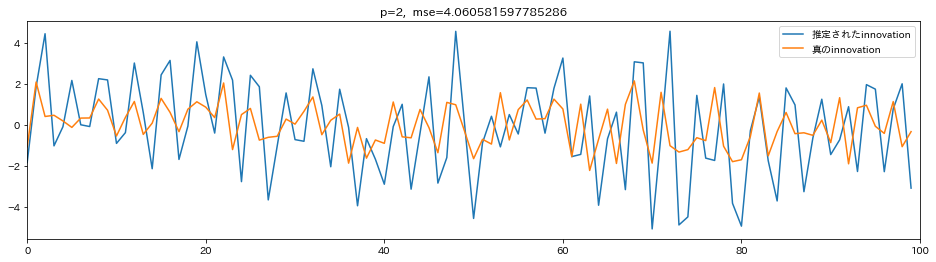

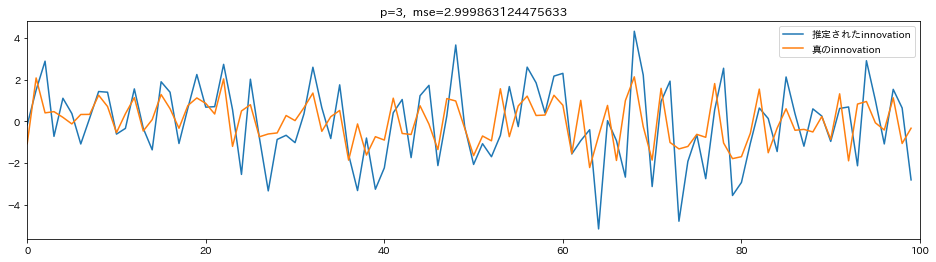

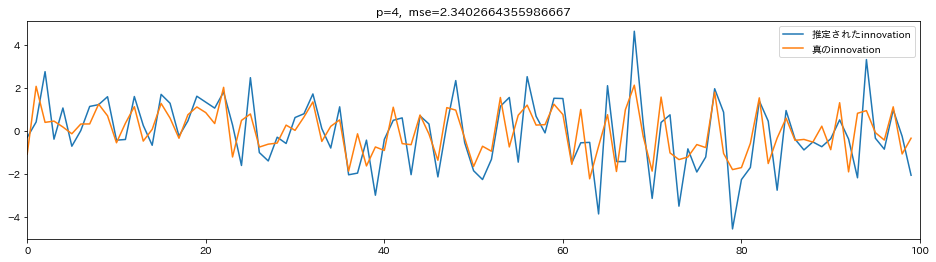

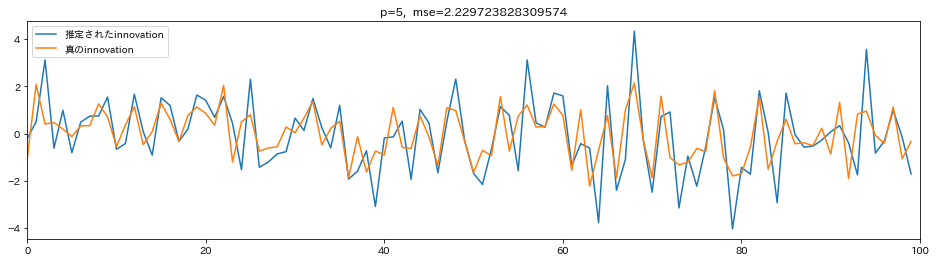

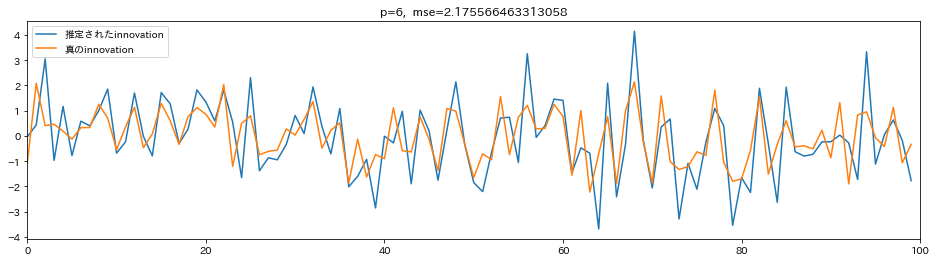

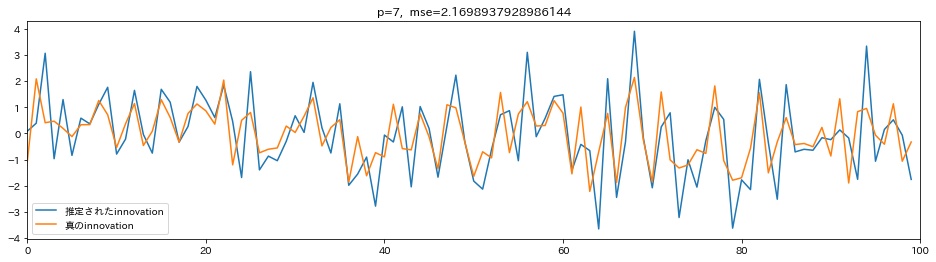

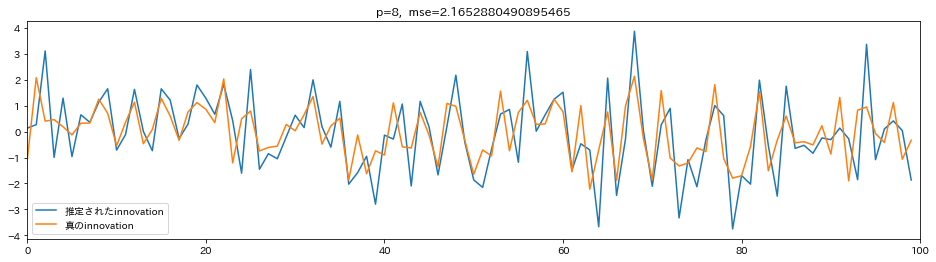

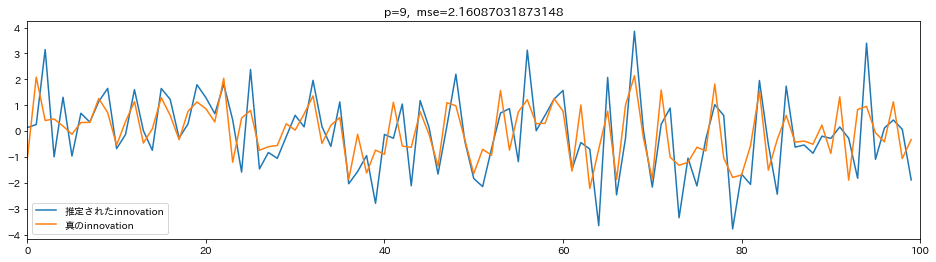

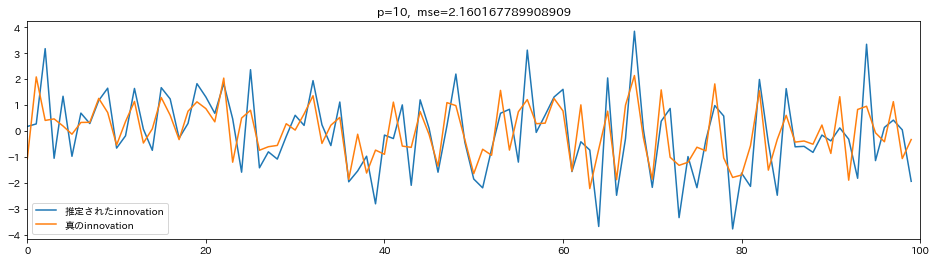

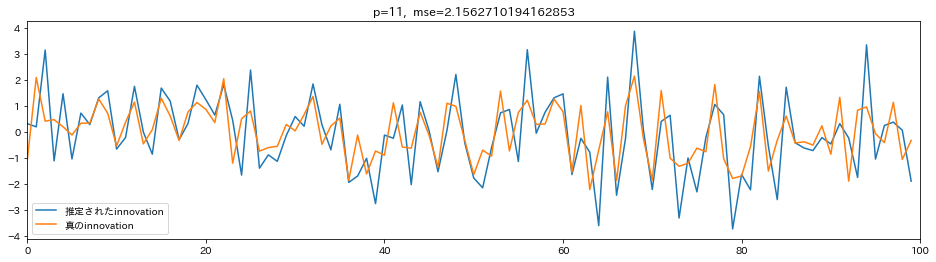

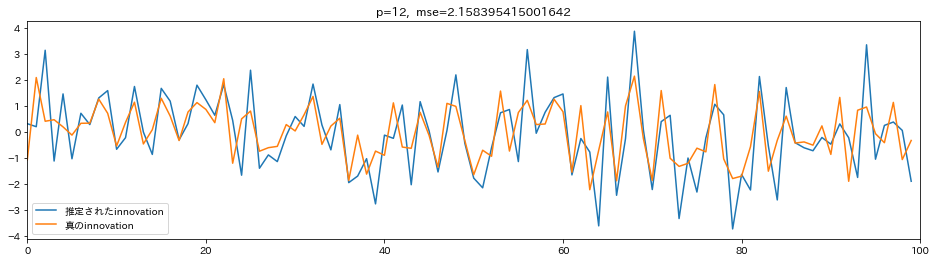

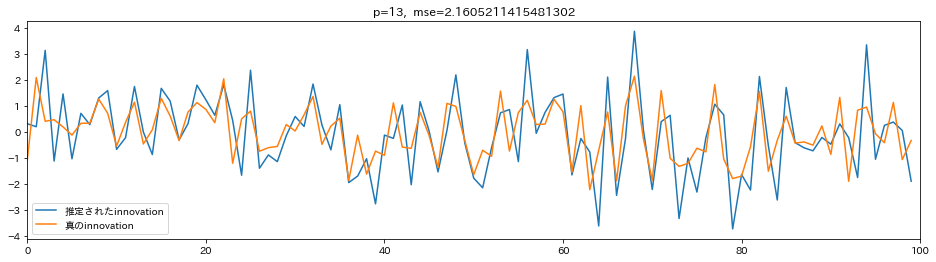

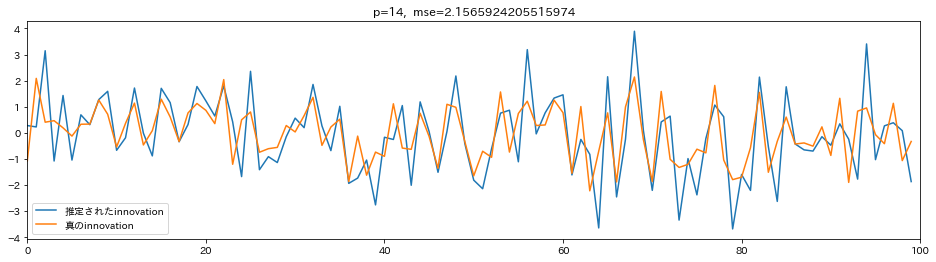

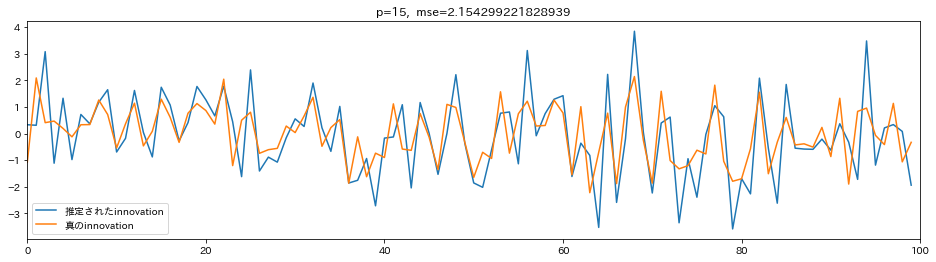

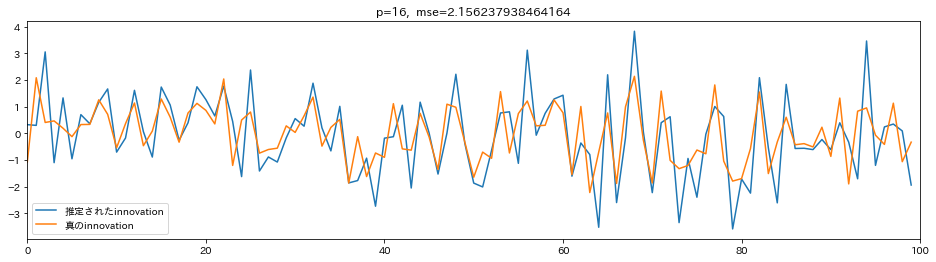

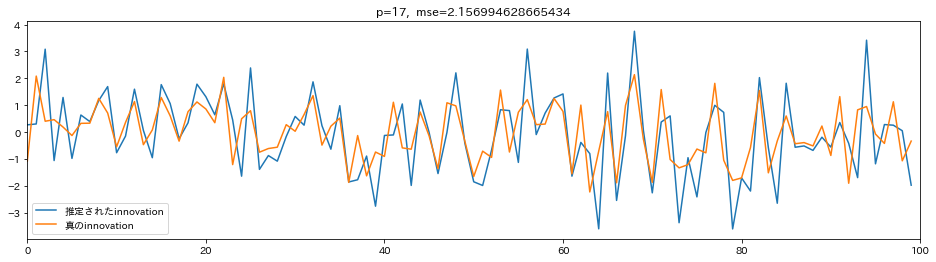

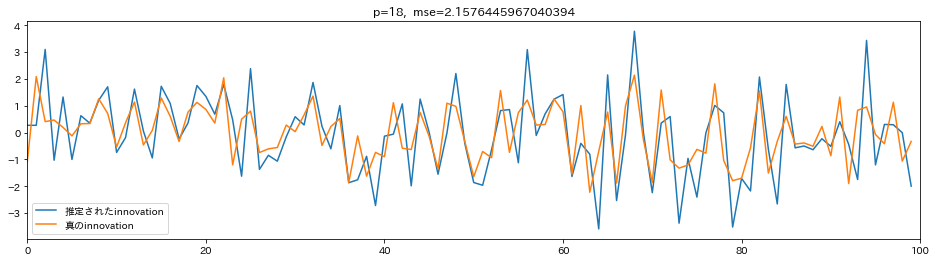

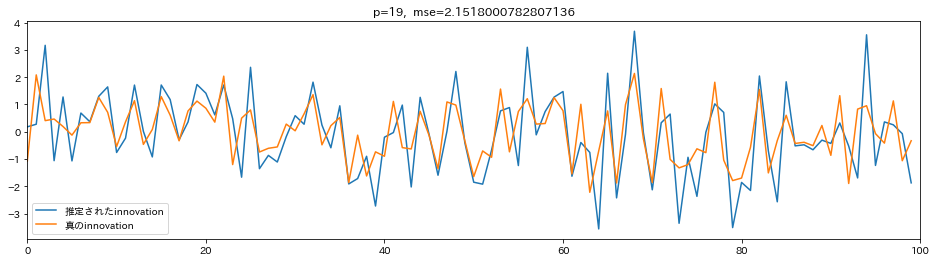

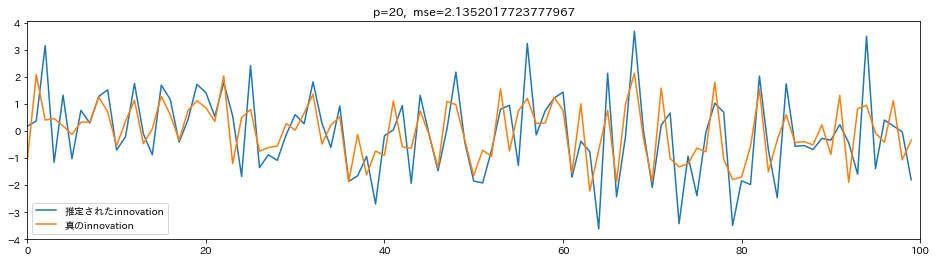

In [281]:
# ARモデルの次数を1から20まで変化させた場合
mse = []
for p in range(1,21):
    res = AutoReg(data, lags = p).fit()
    plt.figure(figsize=(16,4))
    plt.plot((data[p:]-res.predict())[-100:], label='推定されたinnovation')
    mse.append( ((data[p:]-res.predict())**2).sum()/len(data[p:]) )
    plt.plot(inno[-100:], label='真のinnovation')
    plt.legend()
    plt.xlim([0,100])
    plt.title("p={0},  mse={1}".format(p, mse[-1]))
    plt.savefig("/home/lab/ryuichi/Downloads/plot{0}.png".format(p))
    plt.show()

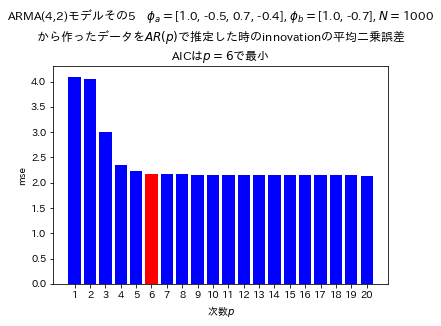

In [282]:
plt.bar(range(1,len(mse)+1), mse, align="center", color=['red' if i+1==mod.ar_lags[-1] else 'blue' for i in range(20)])
plt.xticks(range(1,len(mse)+1))
plt.xlabel("次数$p$")
plt.ylabel('mse')
plt.title('ARMA({0},{1})モデルその{2}　'.format(p_ast,q_ast,dataSeed) + '$\phi_a=${0}, $\phi_b=${1}, $N=${2}'.format(phi_a,phi_b,N)+"\nから作ったデータを$AR(p)$で推定した時のinnovationの平均二乗誤差\nAICは$p={0}$で最小".format(mod.ar_lags[-1]))
plt.savefig("./images/ARMA{0}-{1}_inno-MSE_barplot.png".format(p_ast,q_ast), bbox_inches="tight")

In [325]:
order = sm.tsa.arma_order_select_ic(y=data, max_ar=5, max_ma=3, ic=["aic", "bic"], trend="nc")

In [326]:
order.aic_min_order, order.bic_min_order

((4, 1), (4, 1))

In [345]:
# # ARMAモデルを生成するクラス
# from statsmodels.tsa.arima_process import arma_generate_sample
# np.random.seed(2014)
# y = arma_generate_sample(ar=[1.0, -0.5, 0.7, -0.4], ma=[1.0, -0.7], nsample=1000)
# y

In [312]:
import statsmodels
ARMAmodel = statsmodels.tsa.arima_model.ARMA(endog = data, order=[4,2], exog=None, dates=None, freq=None, missing='none')
result = ARMAmodel.fit(trend="nc")

In [314]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(4, 2)   Log Likelihood               -1805.538
Method:                       css-mle   S.D. of innovations              1.470
Date:                Sun, 27 Sep 2020   AIC                           3625.076
Time:                        12:14:26   BIC                           3659.430
Sample:                             0   HQIC                          3638.133
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.7587      0.184      4.129      0.000       0.399       1.119
ar.L2.y       -0.4275      0.079     -5.391      0.000      -0.583      -0.272
ar.L3.y        0.7110      0.050     14.309      0.000       0.614       0.808
ar.L4.y       -0.3143      0.095     -3.304      0.001      -0.501      -0.128
ma.L1.y        0.4392      0.190      2.312      0.021       0.067       0.812
ma.L2.y       -0.0988      0.148     -0.667      0.505      -0.389       0.191
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.3837           -1.1106j            1.1750           -0.3029
AR.2           -0.3837           +1.1106j            1.1750            0.3029
AR.3            1.5148           -0.1001j            1.5181           -0.0105
AR.4            1.5148           +0.1001j            1.5181            0.0105
MA.1           -1.6584           +0.0000j            1.6584            0.5000
MA.2            6.1061           +0.0000j            6.1061            0.0000
-----------------------------------------------------------------------------
"""

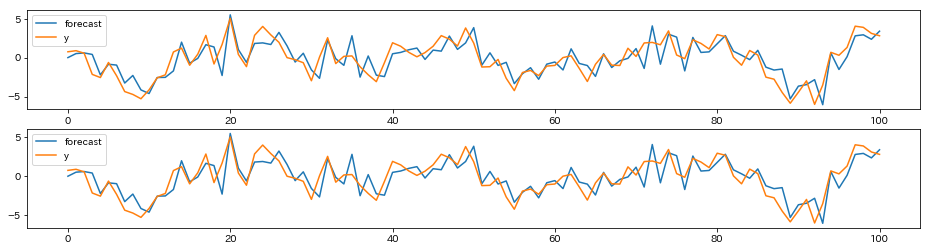

In [357]:
fig = plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(2, 1, 1)
ax1 = plt.plot(result.predict()[0:101], label = 'forecast')
ax1 = plt.plot(data[0:101], label = 'y')
plt.legend()

ax2 = fig.add_subplot(2, 1, 2)
result.plot_predict(start=0, end=100, ax=ax2)
plt.show()

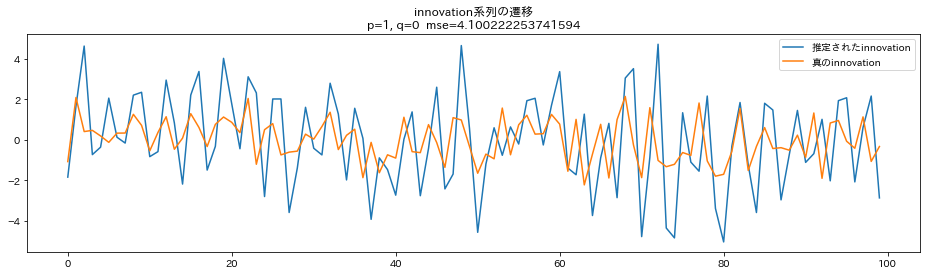

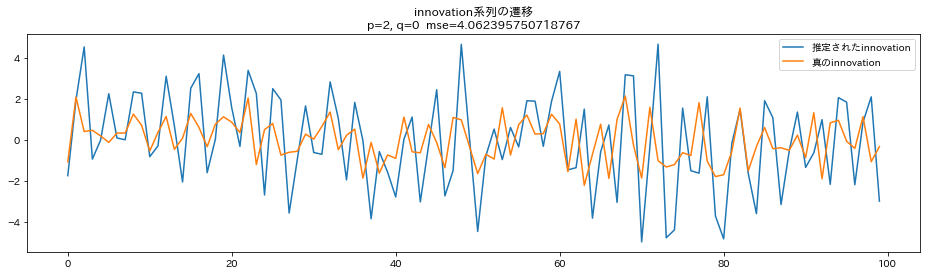

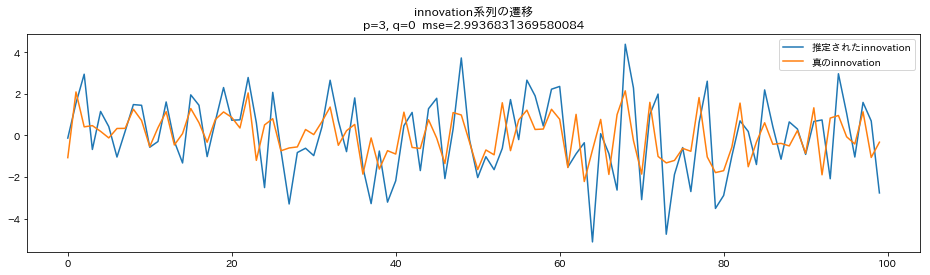

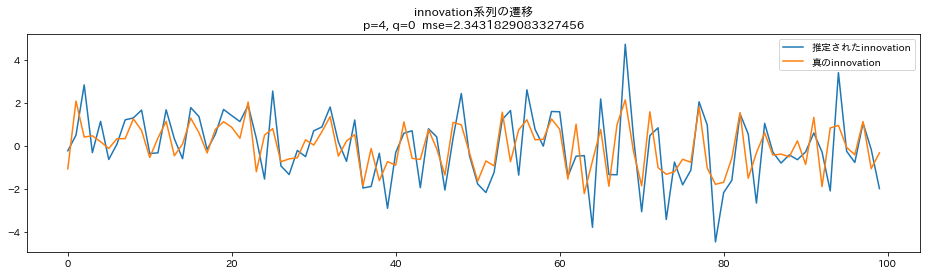

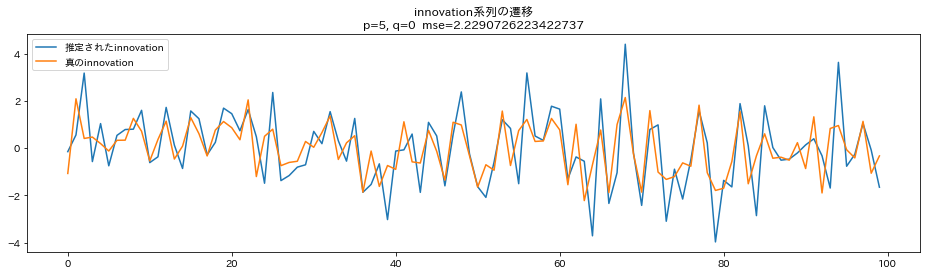

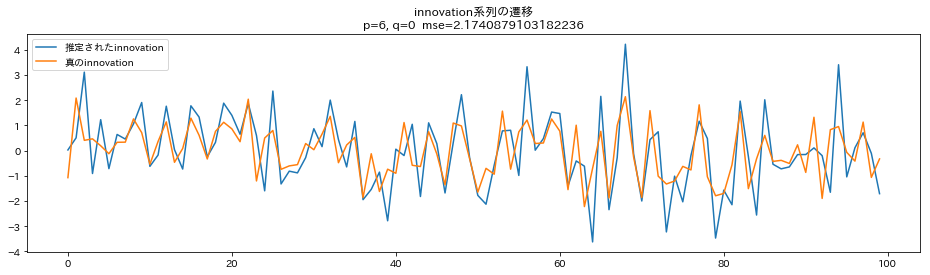

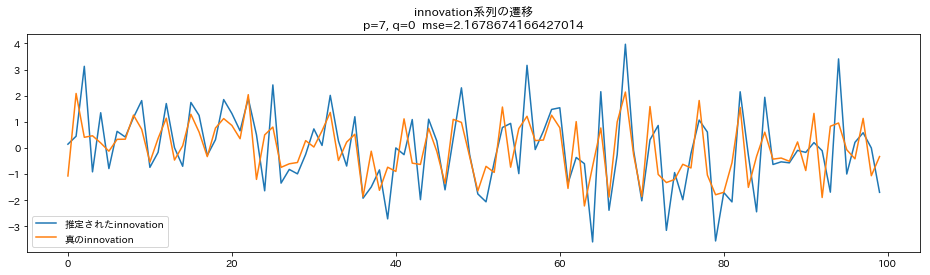

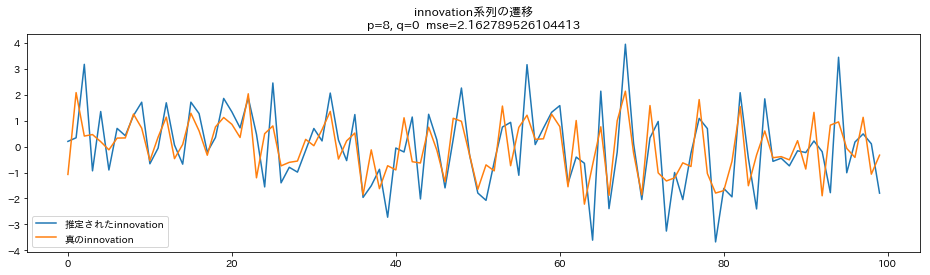

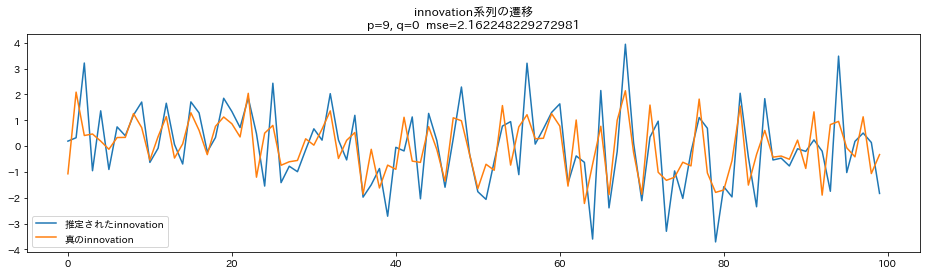

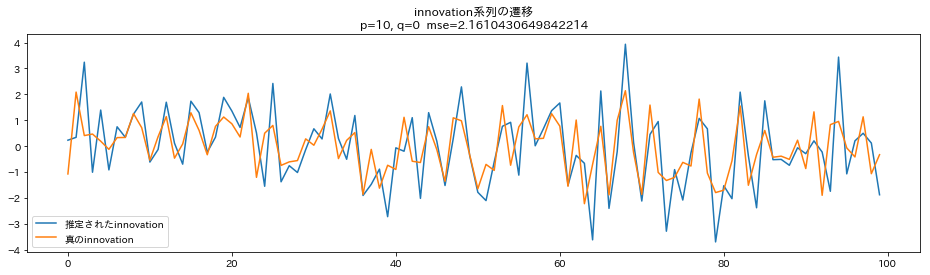

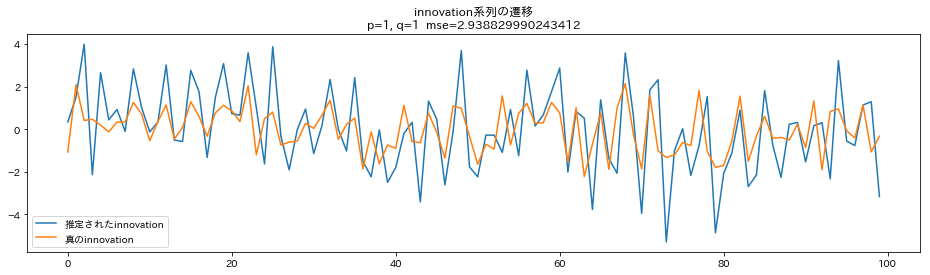

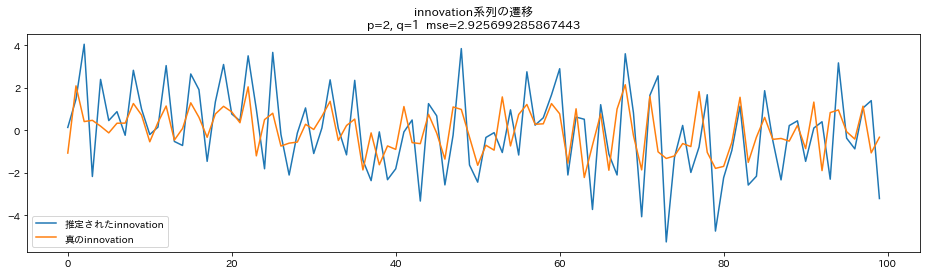

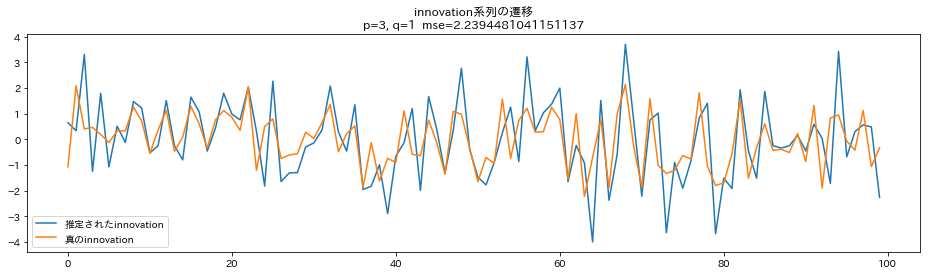

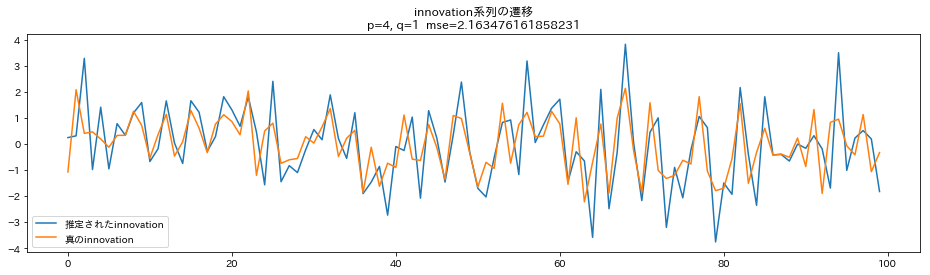

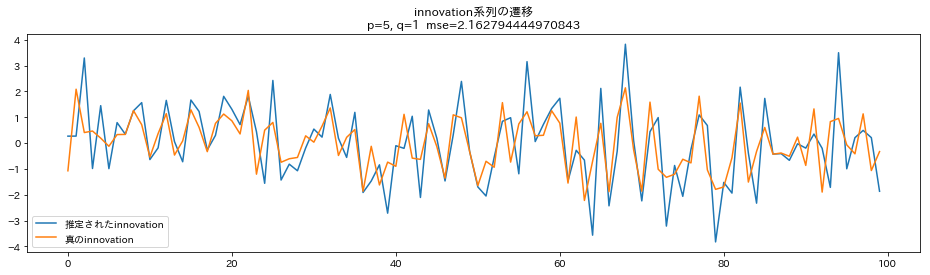

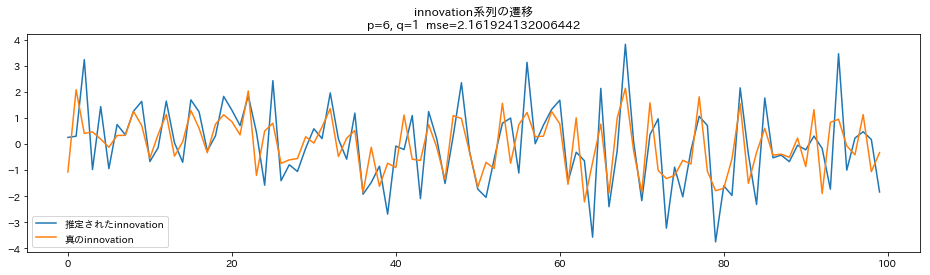

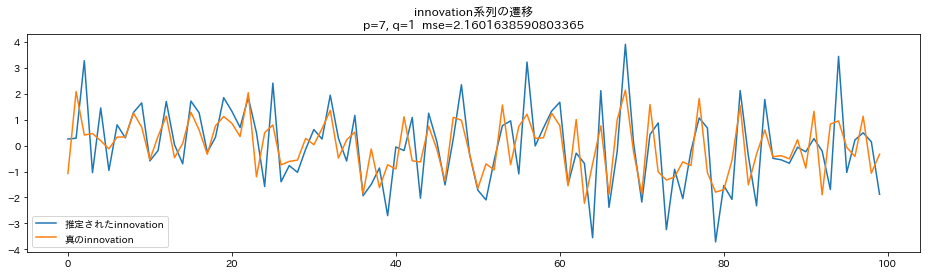

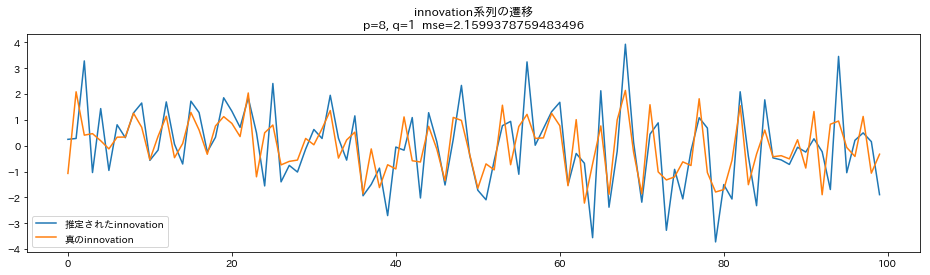

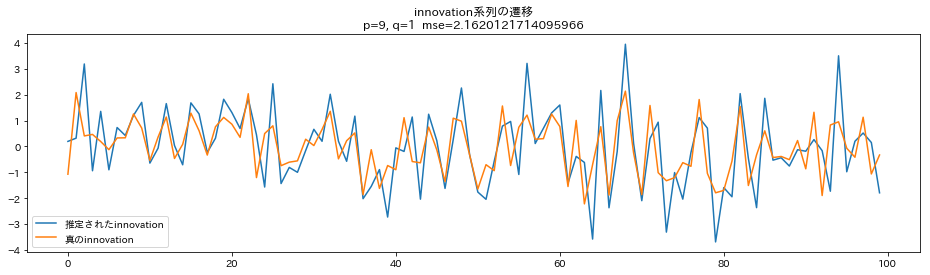

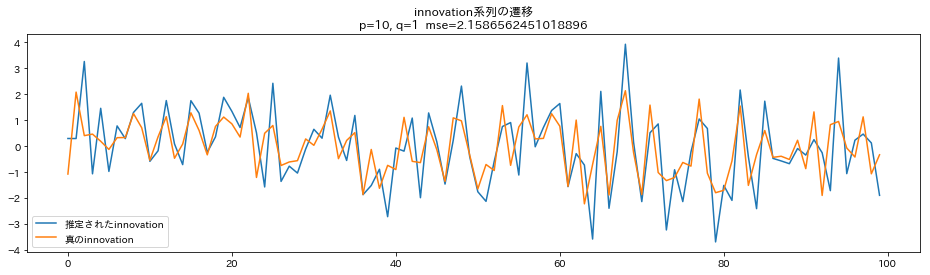

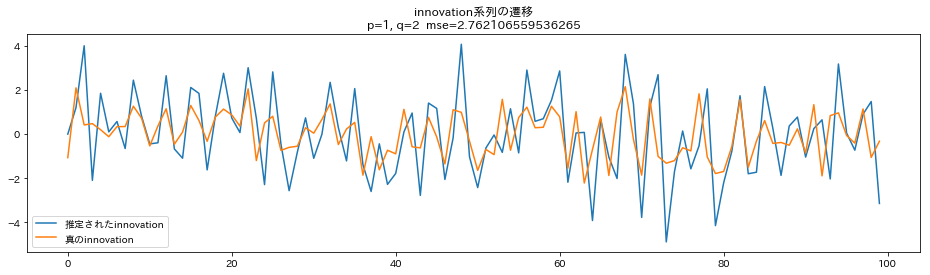

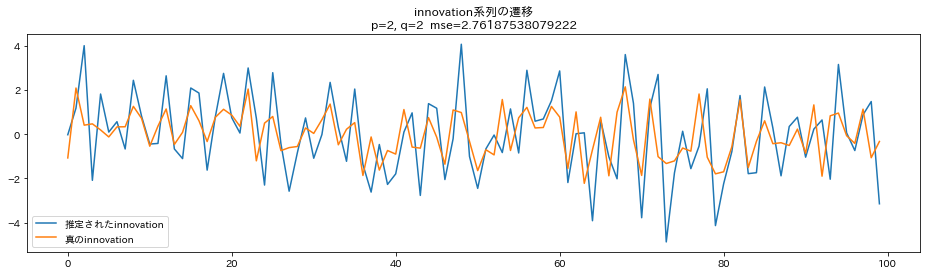

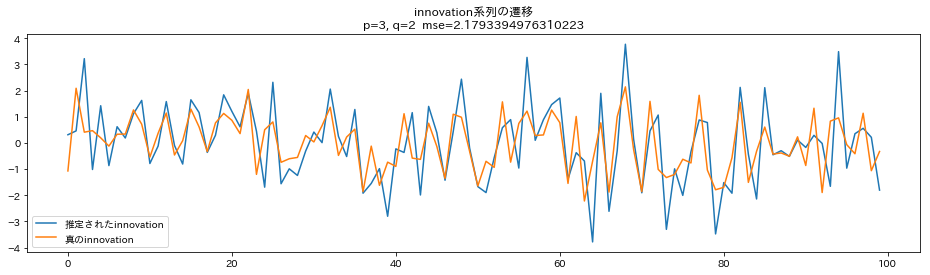

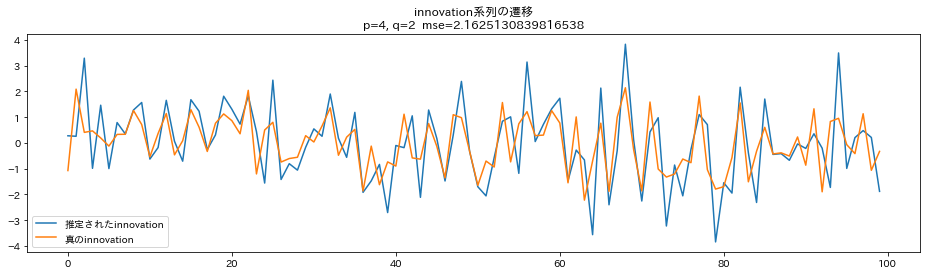

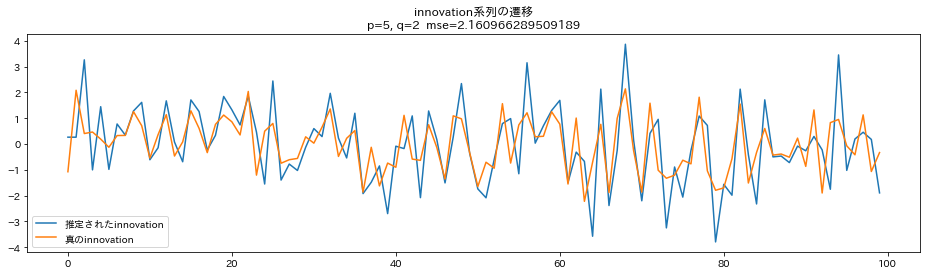

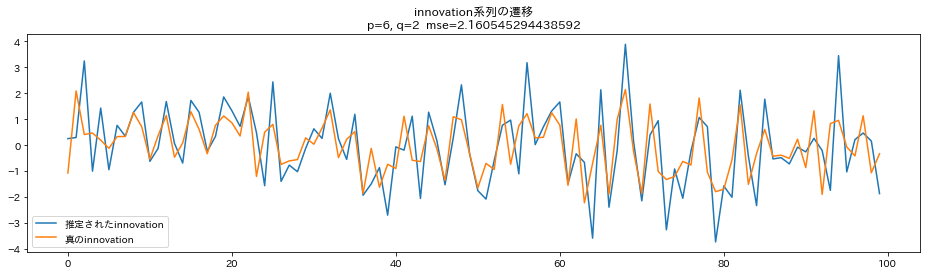

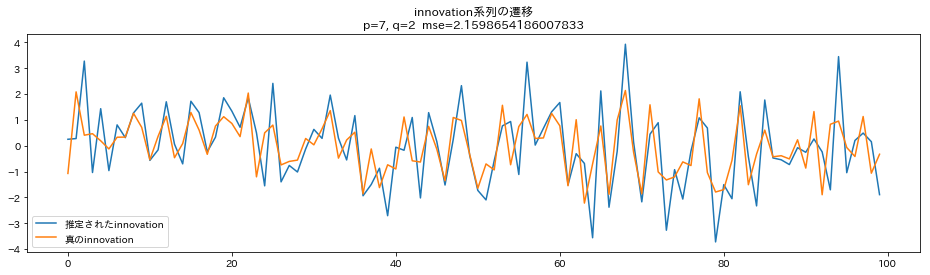

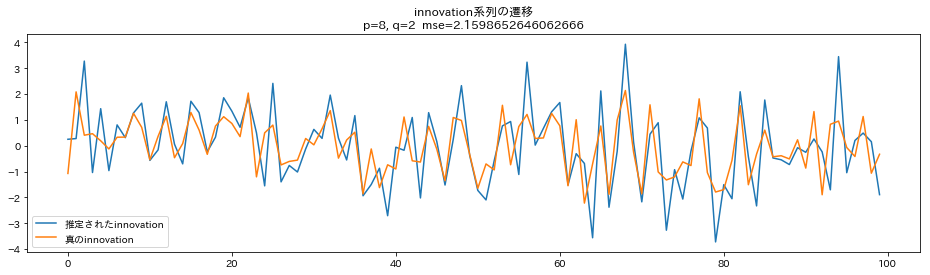

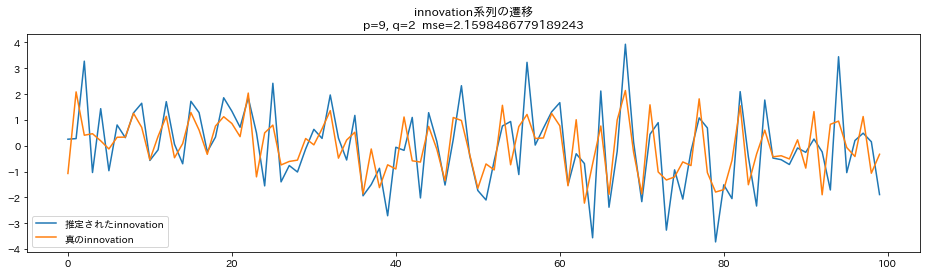

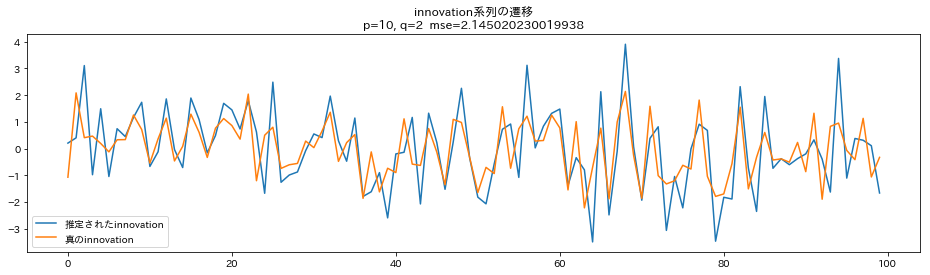

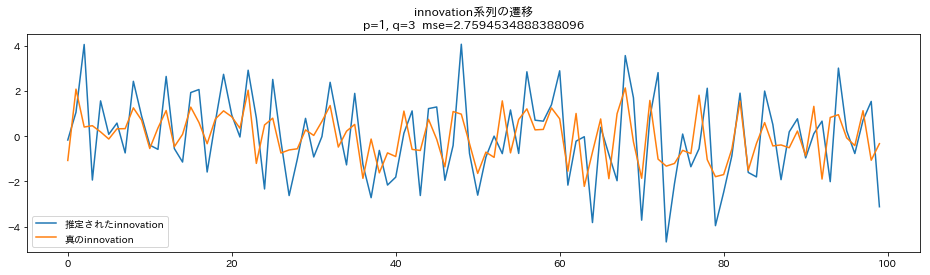

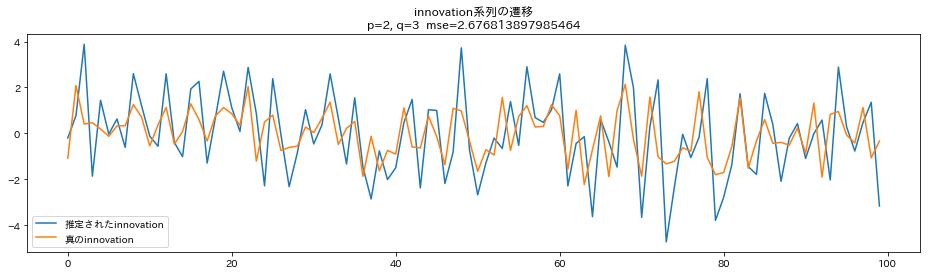

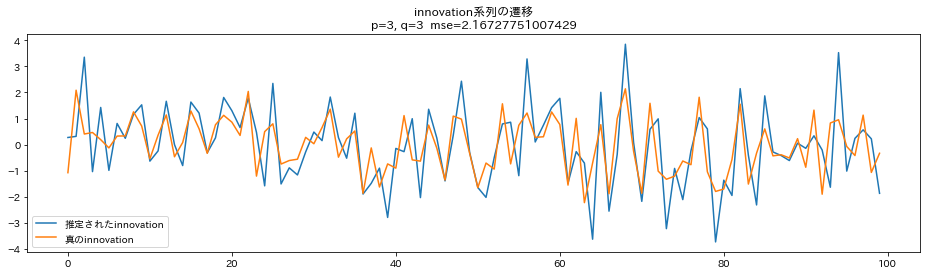

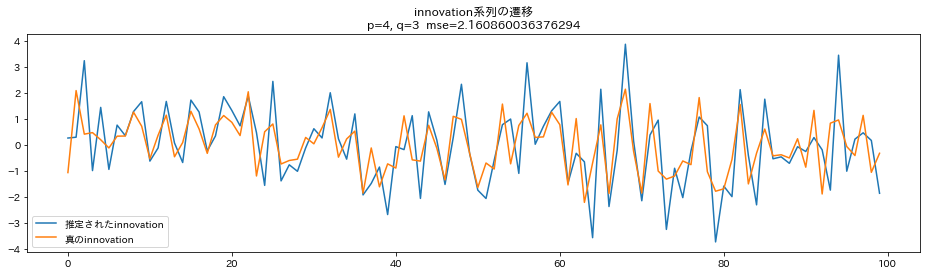

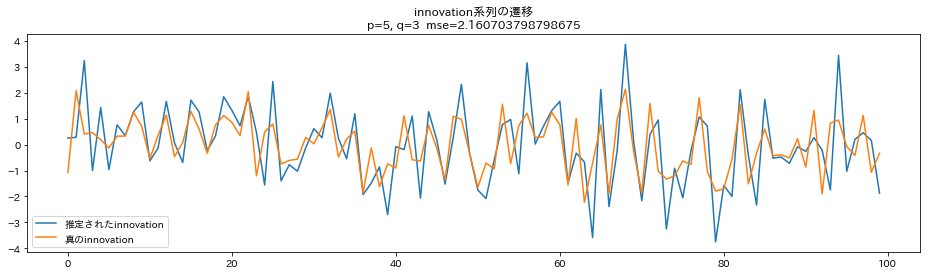

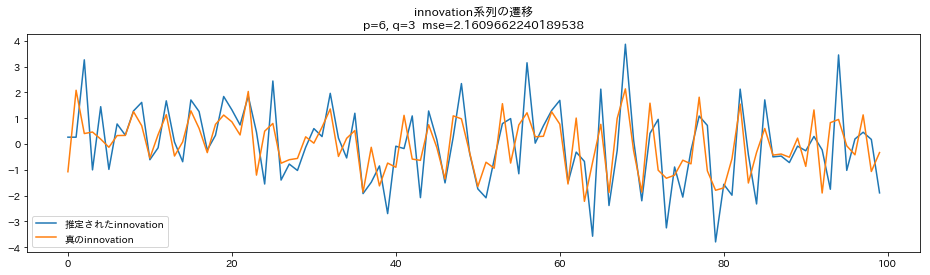

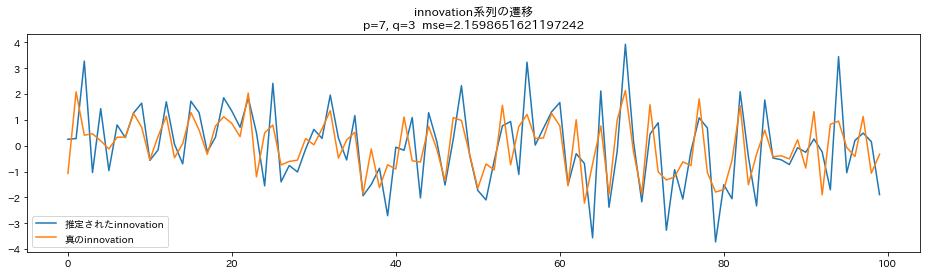

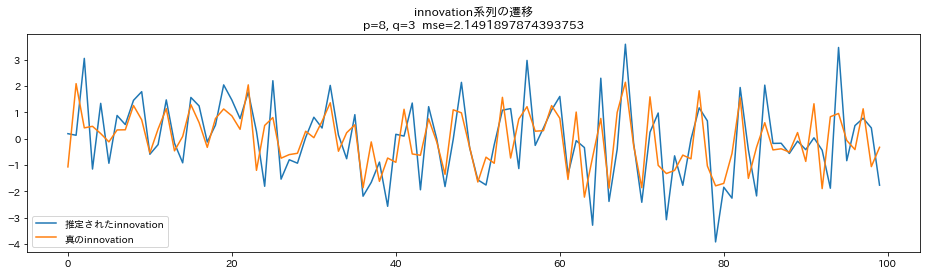

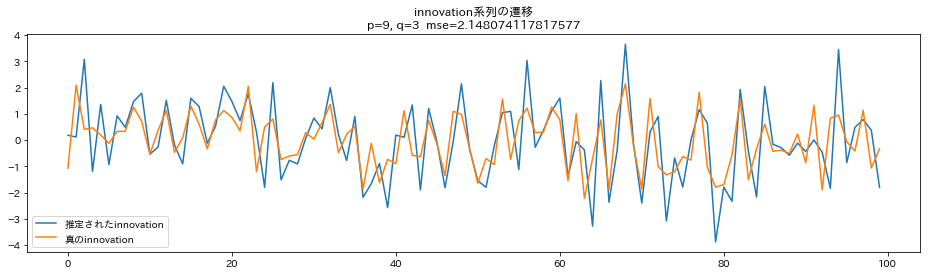

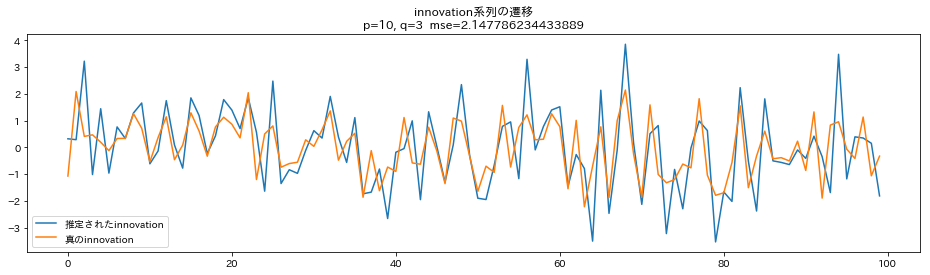

In [376]:
mse = []
for q in range(4):
    q_mse = []
    for p in range(1,11):
        ARMAmodel = statsmodels.tsa.arima_model.ARMA(endog = data, order=[p,q], exog=None, dates=None, freq=None, missing='none')
        try:
            result = ARMAmodel.fit(trend="nc")
        except:
            result = ARMAmodel.fit(start_params=[0]*(p+q), trend="nc")
        q_mse.append(((data-result.predict())**2).sum()/len(data))
        fig = plt.figure(figsize=(16,4))
        ax1 = fig.add_subplot(1, 1, 1)
        ax1 = plt.plot(data[-100:]-result.predict()[-100:], label = '推定されたinnovation')
        ax1 = plt.plot(inno[-100:], label = '真のinnovation')
        plt.legend()
        plt.title("innovation系列の遷移\np={0}, q={1}  mse={2}".format(p, q, q_mse[-1]))
        plt.savefig("./images/predict_inno_ARMA{0}_{1}.png".format(p, q))
        plt.show()
    mse.append(q_mse)

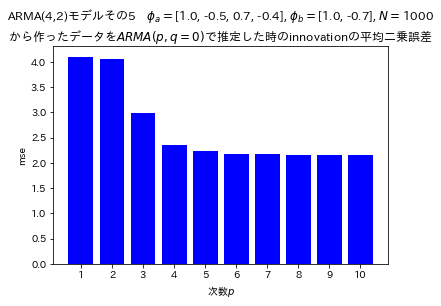

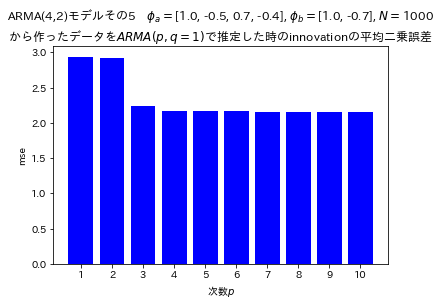

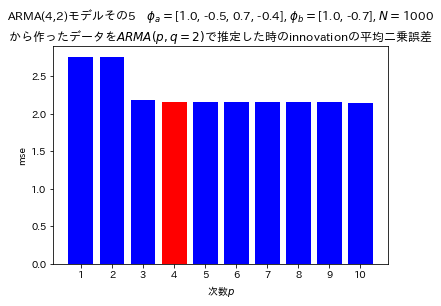

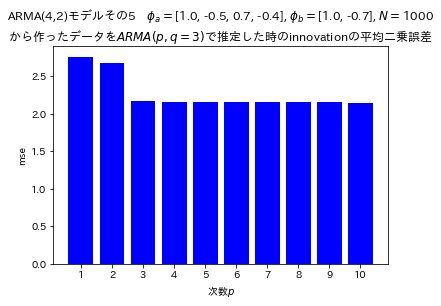

In [375]:
for q in range(4):
    
    len(mse)
    plt.bar(range(1,len(mse[q])+1), mse[q], align="center", color=['red' if q==2 and i==3 else 'blue' for i in range(len(mse[q]))])
    plt.xticks(range(1,len(mse[q])+1))
    plt.xlabel("次数$p$")
    plt.ylabel('mse')
    plt.title('ARMA({0},{1})モデルその{2}　'.format(p_ast,q_ast,dataSeed) + '$\phi_a=${0}, $\phi_b=${1}, $N=${2}'.format(phi_a,phi_b,N)+"\nから作ったデータを$ARMA(p,q={0})$で推定した時のinnovationの平均二乗誤差".format( q))
    plt.savefig("./images/ARMA{0}-{1}_inno-MSE_barplot.png".format(p,q), bbox_inches="tight")
    plt.show()
    

In [300]:
phi_a, phi_b

([1.0, -0.5, 0.7, -0.4], [1.0, -0.7])

# 非線形ARで同じARMAモデル時系列を推定してちゃんとmseが下がるかどうか

In [12]:
hat_p=6

In [13]:
# 学習する推定モデルの形状や学習方法なんかを決定します
# 学習時のハイパラの決定（入力を受け付ける）
parser = argparse.ArgumentParser()
# ランダムシードについて
parser.add_argument("--generator_seed", type=int, default=0, help="generatorのパラメータの初期値のシード")
# parser.add_argument("--discriminator_seed", type=int, default=0, help="discriminatorのパラメータの初期値のシード")
parser.add_argument("--predictor_seed", type=int, default=0, help="predictorのパラメータの初期値のシード")
parser.add_argument("--training_seed", type=int, default=0, help="訓練データを学習させる順番を決めるシード")
# parser.add_argument("--data_seed", type=int, default=0, help="Dataの作成に用いる乱数のseed")
# # 学習方法について
parser.add_argument("--n_epochs", type=int, default=2000, help="Generatorを学習させる回数")
parser.add_argument("--batch_size", type=int, default=64, help="batchの大きさ")
# parser.add_argument("--lr", type=float, default=0.00005, help="学習率")
# parser.add_argument("--n_critic", type=int, default=5, help="一度generatorを更新するごとに何回discriminatorを更新するか")
# parser.add_argument("--discriminator_hidden_unit", type=int, default=64, help="discriminatorの隠れ層のニューロンの数")
# # parser.add_argument("--withGP", type=bool, default=True, help="clipingの代わりにGradient Penaltyを加えるかどうか。True/False")
# # parser.add_argument("--withCorr", type=bool, default=True, help="Generatorの出力がbatch方向に無相関になるようなロスを加えるかどうか。　True/False")
# # モデルの保存やLossの可視化について
parser.add_argument("--sample_interval", type=int, default=100, help="epochを何回まわす度にモデルの保存を行うか")

try:
    opt = parser.parse_args() # .pyの場合はこちらを使用(.ipynbの場合エラーになります)
except:
    opt = parser.parse_args(args=[]) # .ipynbの場合はこちらを使用
print(opt)

Namespace(batch_size=64, generator_seed=0, n_epochs=2000, predictor_seed=0, sample_interval=100, training_seed=0)


usage: ipykernel_launcher.py [-h] [--generator_seed GENERATOR_SEED]
                             [--predictor_seed PREDICTOR_SEED]
                             [--training_seed TRAINING_SEED]
                             [--n_epochs N_EPOCHS] [--batch_size BATCH_SIZE]
                             [--sample_interval SAMPLE_INTERVAL]
ipykernel_launcher.py: error: unrecognized arguments: -f /run/user/1165/jupyter/kernel-98300b93-4b42-4c72-88cb-c2cde6824d6c.json


In [14]:
os.makedirs("output-images/p{0}".format(hat_p), exist_ok=True)
os.makedirs("parameters/p{0}".format(hat_p), exist_ok=True)

In [15]:
import checkGPU
cuda, device = checkGPU.checkGPU()

GPUは使えません。


In [16]:
import models
torch.manual_seed(opt.generator_seed)
generator = models.FullConnectGenerator(p=hat_p, q=0)

In [17]:
a= torch.rand([33,hat_p+1])# 最初はバッチサイズ
print("input size   :",a.shape)
b = generator(a)
print("output size:",b.shape)

input size   : torch.Size([33, 7])
output size: torch.Size([33, 1])


In [18]:
torch.manual_seed(opt.predictor_seed)
predictor = models.predictNet(p=hat_p, q=0)

In [19]:
a= torch.rand([33,hat_p+1])# 最初はバッチサイズ
print("input size   :",a.shape)
b = predictor(a)
print("output size:",b.shape)

input size   : torch.Size([33, 7])
output size: torch.Size([33, 1])


In [20]:
trainDataSet = my_preprocess.DataSet(tsData=data[:900], p=hat_p)
traindataloader = torch.utils.data.DataLoader(trainDataSet, batch_size=opt.batch_size, shuffle=True, drop_last=True)# dataloaderをiterで回すと、毎回入力と出力のペアがlistでくる
valDataSet = my_preprocess.DataSet(tsData=data[100:], p=hat_p)
valdataloader = torch.utils.data.DataLoader(valDataSet, batch_size=opt.batch_size, shuffle=True, drop_last=True)# dataloaderをiterで回すと、毎回入力と出力のペアがlistでくる

In [23]:
# Optimizers(パラメータに対して定義される)
optimizer_G = torch.optim.RMSprop(params=generator.parameters())
# optimizer_D = torch.optim.RMSprop(params=discriminator.parameters(), lr=opt.lr)
# optimizer_F = torch.optim.RMSprop(params=predictor.parameters(), lr=opt.lr)
optimizer_F = torch.optim.Adam(params=predictor.parameters(), lr=0.001 )

# 二条誤差MSE
mseLoss = nn.MSELoss()

# パラメータと学習データをGPUに乗っける
generator.to(device)
# discriminator.to(device)
predictor.to(device)
# trainMatrix=trainMatrix.to(device)
# valMatrix=valMatrix.to(device)
mseLoss.to(device)

MSELoss()

In [24]:
# 訓練データの時系列のどの時刻を学習に用いるかをランダムにしているが、そのランダムシードを固定する
random.seed(a=opt.training_seed)

do_preTrain = bool(int(input('事前学習をここで行いますか、それとも読み込みますか （行う：1, 読み込む：0）  ----> ')))
pretrain_param = 'parameters/p{0}/No{1}_predictor_epoch{2}_batchSize{3}_DataSeed{4}.pth'.format(hat_p, No, 0, opt.batch_size, dataSeed )
if not do_preTrain:
    try:# モデルパラメータを読み込もうとして失敗したら、それはファイルがないと言うことなので、事前学習をこの場で行う
        predictor.load_state_dict(torch.load(pretrain_param)) 
    except:
        print("モデルが存在しないので事前学習を行います")
        do_preTrain=True

事前学習をここで行いますか、それとも読み込みますか （行う：1, 読み込む：0）  ----> 1


In [25]:
if do_preTrain:
    # ここでまずはFの事前学習を行う
    loss_pre = []
    val_loss_pre = []
    pretrain_epoch = 1000
    start=time.time()
    for epoch in range(1, pretrain_epoch+1):# epochごとの処理
        epoch_loss = 0
        for X, Y in traindataloader:
            input_tensor = torch.cat([torch.randn([opt.batch_size,1]).to(device), X.to(device)], axis=1)# ランダムな次元を追加
            optimizer_F.zero_grad()
            loss_F = mseLoss(predictor(input_tensor), Y.to(device))
            loss_F.backward()
            optimizer_F.step()
            epoch_loss += loss_F.item()
        loss_pre.append(epoch_loss/len(traindataloader))
        
        epoch_loss = 0
        for X, Y in valdataloader:
            input_tensor = torch.cat([torch.ones([opt.batch_size,1]).to(device), X.to(device)], axis=1)# ランダムな次元を追加
            loss_F = mseLoss(predictor(input_tensor), Y.to(device))
            epoch_loss += loss_F.item()
        val_loss_pre.append(epoch_loss/len(valdataloader))
        
        print("epoch：{0}/{1}   loss_F：{2: .4f}   経過時間：{3: .1f}秒".format(epoch, pretrain_epoch, round(loss_F.item(), 4), time.time()-start))
        if epoch % 100==0:
            plt.figure(figsize=(13,8))
            plt.title("PredictorのLossの遷移　\n　batchSize:{0}".format(opt.batch_size))
            plt.xlabel("epoch")
            plt.ylabel("Loss")
            plt.plot(loss_pre, label="training")
            plt.plot(val_loss_pre, label="validation")
            plt.legend()
            plt.savefig("preloss.png")
            plt.close()
    torch.save(predictor.state_dict(), pretrain_param)
    
    plt.figure(figsize=(13,8))
    plt.title("PredictorのLossの遷移　\n　batchSize:{0}".format(opt.batch_size))
    plt.xlabel("epoch")
    plt.ylabel("Loss")
    plt.plot(loss_pre, label="training")
    plt.plot(val_loss_pre, label="validation")
    plt.legend()
    plt.savefig("output-images/p{0}/No{1}_preloss_epoch{2}_batchSize{3}_DataSeed{4}.png".format(hat_p, No, epoch, opt.batch_size, dataSeed ))
    plt.close()
    print("pre-training終了")
print("モデルの保存先：",pretrain_param)

epoch：1/1000   loss_F： 9.2481   経過時間： 0.0秒
epoch：2/1000   loss_F： 6.5411   経過時間： 0.1秒
epoch：3/1000   loss_F： 11.0825   経過時間： 0.1秒
epoch：4/1000   loss_F： 10.0010   経過時間： 0.2秒
epoch：5/1000   loss_F： 8.4990   経過時間： 0.2秒
epoch：6/1000   loss_F： 8.2122   経過時間： 0.3秒
epoch：7/1000   loss_F： 8.8607   経過時間： 0.3秒
epoch：8/1000   loss_F： 6.6130   経過時間： 0.4秒
epoch：9/1000   loss_F： 10.1760   経過時間： 0.4秒
epoch：10/1000   loss_F： 6.0164   経過時間： 0.4秒
epoch：11/1000   loss_F： 8.2108   経過時間： 0.5秒
epoch：12/1000   loss_F： 9.8191   経過時間： 0.5秒
epoch：13/1000   loss_F： 8.4692   経過時間： 0.6秒
epoch：14/1000   loss_F： 6.5540   経過時間： 0.6秒
epoch：15/1000   loss_F： 8.3208   経過時間： 0.7秒
epoch：16/1000   loss_F： 9.0500   経過時間： 0.7秒
epoch：17/1000   loss_F： 9.8871   経過時間： 0.8秒
epoch：18/1000   loss_F： 7.5593   経過時間： 0.8秒
epoch：19/1000   loss_F： 8.8977   経過時間： 0.8秒
epoch：20/1000   loss_F： 6.8079   経過時間： 0.9秒
epoch：21/1000   loss_F： 7.5311   経過時間： 0.9秒
epoch：22/1000   loss_F： 7.0702   経過時間： 1.0秒
epoch：23/1000   loss_F： 8.4513   経過時間：

epoch：186/1000   loss_F： 10.7649   経過時間： 8.5秒
epoch：187/1000   loss_F： 9.4483   経過時間： 8.5秒
epoch：188/1000   loss_F： 8.7647   経過時間： 8.6秒
epoch：189/1000   loss_F： 7.7596   経過時間： 8.6秒
epoch：190/1000   loss_F： 7.6814   経過時間： 8.7秒
epoch：191/1000   loss_F： 7.4185   経過時間： 8.7秒
epoch：192/1000   loss_F： 7.5173   経過時間： 8.7秒
epoch：193/1000   loss_F： 5.4394   経過時間： 8.8秒
epoch：194/1000   loss_F： 7.5213   経過時間： 8.8秒
epoch：195/1000   loss_F： 9.1304   経過時間： 8.9秒
epoch：196/1000   loss_F： 8.2508   経過時間： 8.9秒
epoch：197/1000   loss_F： 7.0806   経過時間： 9.0秒
epoch：198/1000   loss_F： 8.3168   経過時間： 9.0秒
epoch：199/1000   loss_F： 9.6474   経過時間： 9.1秒
epoch：200/1000   loss_F： 8.3819   経過時間： 9.1秒
epoch：201/1000   loss_F： 7.4996   経過時間： 9.4秒
epoch：202/1000   loss_F： 7.2401   経過時間： 9.5秒
epoch：203/1000   loss_F： 9.4729   経過時間： 9.5秒
epoch：204/1000   loss_F： 6.1619   経過時間： 9.6秒
epoch：205/1000   loss_F： 9.2562   経過時間： 9.6秒
epoch：206/1000   loss_F： 7.1983   経過時間： 9.7秒
epoch：207/1000   loss_F： 9.3485   経過時間： 9.7秒
epoch：208

epoch：366/1000   loss_F： 7.2407   経過時間： 17.0秒
epoch：367/1000   loss_F： 8.9426   経過時間： 17.0秒
epoch：368/1000   loss_F： 6.1826   経過時間： 17.0秒
epoch：369/1000   loss_F： 7.0171   経過時間： 17.1秒
epoch：370/1000   loss_F： 9.4547   経過時間： 17.1秒
epoch：371/1000   loss_F： 6.5689   経過時間： 17.2秒
epoch：372/1000   loss_F： 8.5967   経過時間： 17.2秒
epoch：373/1000   loss_F： 8.9206   経過時間： 17.3秒
epoch：374/1000   loss_F： 7.8526   経過時間： 17.3秒
epoch：375/1000   loss_F： 9.5737   経過時間： 17.3秒
epoch：376/1000   loss_F： 8.5598   経過時間： 17.4秒
epoch：377/1000   loss_F： 7.7902   経過時間： 17.4秒
epoch：378/1000   loss_F： 8.4706   経過時間： 17.5秒
epoch：379/1000   loss_F： 9.5548   経過時間： 17.5秒
epoch：380/1000   loss_F： 8.3626   経過時間： 17.6秒
epoch：381/1000   loss_F： 8.9402   経過時間： 17.6秒
epoch：382/1000   loss_F： 8.1194   経過時間： 17.7秒
epoch：383/1000   loss_F： 8.8207   経過時間： 17.7秒
epoch：384/1000   loss_F： 6.9991   経過時間： 17.7秒
epoch：385/1000   loss_F： 5.5672   経過時間： 17.8秒
epoch：386/1000   loss_F： 8.8431   経過時間： 17.8秒
epoch：387/1000   loss_F： 9.1616   

epoch：546/1000   loss_F： 8.5334   経過時間： 25.3秒
epoch：547/1000   loss_F： 7.6184   経過時間： 25.4秒
epoch：548/1000   loss_F： 8.2047   経過時間： 25.4秒
epoch：549/1000   loss_F： 7.6850   経過時間： 25.5秒
epoch：550/1000   loss_F： 9.7568   経過時間： 25.5秒
epoch：551/1000   loss_F： 7.4480   経過時間： 25.6秒
epoch：552/1000   loss_F： 8.6677   経過時間： 25.6秒
epoch：553/1000   loss_F： 7.9414   経過時間： 25.6秒
epoch：554/1000   loss_F： 5.8433   経過時間： 25.7秒
epoch：555/1000   loss_F： 7.8478   経過時間： 25.7秒
epoch：556/1000   loss_F： 7.6168   経過時間： 25.8秒
epoch：557/1000   loss_F： 8.0172   経過時間： 25.8秒
epoch：558/1000   loss_F： 11.1170   経過時間： 25.9秒
epoch：559/1000   loss_F： 6.5788   経過時間： 25.9秒
epoch：560/1000   loss_F： 7.0972   経過時間： 25.9秒
epoch：561/1000   loss_F： 9.4018   経過時間： 26.0秒
epoch：562/1000   loss_F： 8.4904   経過時間： 26.0秒
epoch：563/1000   loss_F： 8.3490   経過時間： 26.1秒
epoch：564/1000   loss_F： 9.4625   経過時間： 26.1秒
epoch：565/1000   loss_F： 7.0947   経過時間： 26.2秒
epoch：566/1000   loss_F： 9.6032   経過時間： 26.2秒
epoch：567/1000   loss_F： 8.4347  

epoch：726/1000   loss_F： 7.7032   経過時間： 33.7秒
epoch：727/1000   loss_F： 7.8795   経過時間： 33.7秒
epoch：728/1000   loss_F： 8.8383   経過時間： 33.8秒
epoch：729/1000   loss_F： 7.8354   経過時間： 33.8秒
epoch：730/1000   loss_F： 8.8739   経過時間： 33.8秒
epoch：731/1000   loss_F： 9.2562   経過時間： 33.9秒
epoch：732/1000   loss_F： 7.1373   経過時間： 33.9秒
epoch：733/1000   loss_F： 9.7178   経過時間： 34.0秒
epoch：734/1000   loss_F： 6.6153   経過時間： 34.0秒
epoch：735/1000   loss_F： 6.0800   経過時間： 34.1秒
epoch：736/1000   loss_F： 6.4900   経過時間： 34.1秒
epoch：737/1000   loss_F： 8.5510   経過時間： 34.1秒
epoch：738/1000   loss_F： 7.3151   経過時間： 34.2秒
epoch：739/1000   loss_F： 7.7691   経過時間： 34.2秒
epoch：740/1000   loss_F： 11.3769   経過時間： 34.3秒
epoch：741/1000   loss_F： 8.6364   経過時間： 34.3秒
epoch：742/1000   loss_F： 6.8022   経過時間： 34.4秒
epoch：743/1000   loss_F： 8.4395   経過時間： 34.4秒
epoch：744/1000   loss_F： 11.8231   経過時間： 34.4秒
epoch：745/1000   loss_F： 8.3120   経過時間： 34.5秒
epoch：746/1000   loss_F： 7.0407   経過時間： 34.5秒
epoch：747/1000   loss_F： 6.6585 

epoch：906/1000   loss_F： 9.2750   経過時間： 42.0秒
epoch：907/1000   loss_F： 8.6998   経過時間： 42.1秒
epoch：908/1000   loss_F： 6.9307   経過時間： 42.1秒
epoch：909/1000   loss_F： 8.7632   経過時間： 42.1秒
epoch：910/1000   loss_F： 8.0575   経過時間： 42.2秒
epoch：911/1000   loss_F： 7.2126   経過時間： 42.2秒
epoch：912/1000   loss_F： 10.5959   経過時間： 42.3秒
epoch：913/1000   loss_F： 8.1867   経過時間： 42.3秒
epoch：914/1000   loss_F： 9.0657   経過時間： 42.4秒
epoch：915/1000   loss_F： 7.1883   経過時間： 42.4秒
epoch：916/1000   loss_F： 9.2112   経過時間： 42.4秒
epoch：917/1000   loss_F： 9.0101   経過時間： 42.5秒
epoch：918/1000   loss_F： 7.1521   経過時間： 42.5秒
epoch：919/1000   loss_F： 11.7646   経過時間： 42.6秒
epoch：920/1000   loss_F： 7.0585   経過時間： 42.6秒
epoch：921/1000   loss_F： 7.2172   経過時間： 42.6秒
epoch：922/1000   loss_F： 8.5309   経過時間： 42.7秒
epoch：923/1000   loss_F： 8.0961   経過時間： 42.7秒
epoch：924/1000   loss_F： 8.2712   経過時間： 42.8秒
epoch：925/1000   loss_F： 7.5533   経過時間： 42.8秒
epoch：926/1000   loss_F： 6.7565   経過時間： 42.9秒
epoch：927/1000   loss_F： 10.4173

In [26]:
saveModel = input('作成したモデルを {0} epochごとに逐次保存しますか？ （Yes：1, No：0）  ----> '.format(opt.sample_interval))
saveModel = bool(int(saveModel))

作成したモデルを 100 epochごとに逐次保存しますか？ （Yes：1, No：0）  ----> 1


In [27]:
trainDataSet = my_preprocess.DataSet_forGandF(tsData=data[:900], p=hat_p)
traindataloader = torch.utils.data.DataLoader(trainDataSet, batch_size=opt.batch_size, shuffle=True, drop_last=True)# dataloaderをiterで回すと、毎回入力と出力のペアがlistでくる
valDataSet = my_preprocess.DataSet_forGandF(tsData=data[900:], p=hat_p)
valdataloader = torch.utils.data.DataLoader(valDataSet, batch_size=opt.batch_size, shuffle=True, drop_last=True)# dataloaderをiterで回すと、毎回入力と出力のペアがlistでくる

In [31]:
min_floss=np.inf# epochのflossのの最小値を保管
start=time.time()
# epochごとにbatchで計算したlossを平均した値をloss_curveとして描きたい
loss_Wasserstein = []
loss_mse = []
val_loss_Wasserstein = []
val_loss_mse = []

for epoch in range(1, opt.n_epochs+1):# epochごとの処理(discriminatorのepoch)

    
    epoch_loss_Wasserstein = 0
    epoch_loss_mse = 0
    for X, Y in traindataloader:
        # Wasserstein距離に基づくGeneratorの学習
        loss_G = Wasserstein.pWasserstein(generator(X.to(device)), p=1)
        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()
        epoch_loss_Wasserstein += loss_G.item()
        # Fの学習
        input_tensor = torch.cat([generator(X).to(device), (X[:,:-1]).to(device)], axis=1)
        loss_F = mseLoss(predictor(input_tensor), Y.to(device))
        optimizer_G.zero_grad()
        optimizer_F.zero_grad()
        loss_F.backward()
        optimizer_F.step()
        optimizer_G.step()
        epoch_loss_mse += loss_F.item()
    loss_Wasserstein.append(epoch_loss_Wasserstein/len(traindataloader))
    loss_mse.append(epoch_loss_mse/len(traindataloader))
    
    epoch_loss_Wasserstein = 0
    epoch_loss_mse = 0
    for X, Y in traindataloader:
        loss_G = Wasserstein.pWasserstein(generator(X.to(device)), p=1)
        epoch_loss_Wasserstein += loss_G.item()
        input_tensor = torch.cat([generator(X).to(device), (X[:,:-1]).to(device)], axis=1)
        loss_F = mseLoss(predictor(input_tensor), Y.to(device))
        epoch_loss_mse += loss_F.item()
    val_loss_Wasserstein.append(epoch_loss_Wasserstein/len(valdataloader))
    val_loss_mse.append(epoch_loss_mse/len(valdataloader))
    
    print("epoch：{0}/{1}   loss_Wass：{2: .4f}    loss_mse：{3: .4f}     経過時間：{4: .1f}秒".format(epoch, opt.n_epochs, round(loss_Wasserstein[-1], 4), round(loss_mse[-1], 4), time.time()-start))
             
    if saveModel and epoch % opt.sample_interval == 0:
        torch.save(generator.state_dict(), 'parameters/p'+str(hat_p)+'/No{0}_generator_epoch{1}_batchSize{2}_DataSeed{3}.pth'.format(No, epoch, opt.batch_size, dataSeed))
        torch.save(predictor.state_dict(), 'parameters/p'+str(hat_p)+'/No{0}_predictor_epoch{1}_batchSize{2}_DataSeed{3}.pth'.format(No, epoch, opt.batch_size, dataSeed))
  
    if epoch % 100==0:

        plt.figure(figsize=(13,8))
        plt.title("Wasserstein距離のLossの遷移　\n　batchSize:{0}".format(opt.batch_size))
        plt.xlabel("epoch")
        plt.ylabel("Loss")
        plt.plot(loss_Wasserstein, label="training")
        plt.plot(val_loss_Wasserstein, label="validation")
        plt.legend()
        plt.savefig("gloss.png")
        plt.close()
        
        plt.figure(figsize=(13,8))
        plt.title("PredictorのLossの遷移　\n　batchSize:{0}".format(opt.batch_size))
        plt.xlabel("epoch")
        plt.ylabel("Loss")
        plt.plot(loss_mse, label="training")
        plt.plot(val_loss_mse, label="validation")
        plt.legend()
        plt.savefig("floss.png")
        plt.close()
#     break
torch.save(generator.state_dict(), 'parameters/p'+str(hat_p)+'/No{0}_generator_epoch{1}_batchSize{2}_DataSeed{3}.pth'.format(No, epoch, opt.batch_size, dataSeed))
torch.save(predictor.state_dict(), 'parameters/p'+str(hat_p)+'/No{0}_predictor_epoch{1}_batchSize{2}_DataSeed{3}.pth'.format(No, epoch, opt.batch_size, dataSeed))

plt.figure(figsize=(13,8))
plt.title("Wasserstein距離のLossの遷移　\n　batchSize:{0}".format(opt.batch_size))
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.plot(loss_Wasserstein, label="training")
plt.plot(val_loss_Wasserstein, label="validation")
plt.legend()
plt.savefig("output-images/p{0}/No{1}_gloss_epoch{2}_batchSize{3}_DataSeed{4}.png".format(hat_p, No, epoch, opt.batch_size, dataSeed ))
plt.close()

plt.figure(figsize=(13,8))
plt.title("PredictorのLossの遷移　\n　batchSize:{0}".format(opt.batch_size))
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.plot(loss_mse, label="training")
plt.plot(val_loss_mse, label="validation")
plt.legend()
plt.savefig("output-images/p{0}/No{1}_floss_epoch{2}_batchSize{3}_DataSeed{4}.png".format(hat_p, No, epoch, opt.batch_size, dataSeed ))
plt.close()


epoch：1/2000   loss_Wass： 0.8025    loss_mse： 7.6869     経過時間： 2.8秒
epoch：2/2000   loss_Wass： 0.8027    loss_mse： 7.5927     経過時間： 5.7秒
epoch：3/2000   loss_Wass： 0.8040    loss_mse： 7.6578     経過時間： 8.5秒
epoch：4/2000   loss_Wass： 0.7972    loss_mse： 7.6624     経過時間： 11.3秒
epoch：5/2000   loss_Wass： 0.8028    loss_mse： 7.6630     経過時間： 14.1秒
epoch：6/2000   loss_Wass： 0.7970    loss_mse： 7.6578     経過時間： 16.9秒
epoch：7/2000   loss_Wass： 0.8030    loss_mse： 7.5825     経過時間： 19.7秒
epoch：8/2000   loss_Wass： 0.8004    loss_mse： 7.6921     経過時間： 22.5秒
epoch：9/2000   loss_Wass： 0.7996    loss_mse： 7.6812     経過時間： 25.3秒
epoch：10/2000   loss_Wass： 0.7997    loss_mse： 7.5237     経過時間： 28.1秒
epoch：11/2000   loss_Wass： 0.8024    loss_mse： 7.6066     経過時間： 30.9秒
epoch：12/2000   loss_Wass： 0.7991    loss_mse： 7.7475     経過時間： 33.7秒
epoch：13/2000   loss_Wass： 0.8012    loss_mse： 7.9142     経過時間： 36.5秒
epoch：14/2000   loss_Wass： 0.7986    loss_mse： 7.6354     経過時間： 39.3秒
epoch：15/2000   loss_Wass： 0.801

epoch：117/2000   loss_Wass： 0.8006    loss_mse： 7.7800     経過時間： 330.7秒
epoch：118/2000   loss_Wass： 0.7984    loss_mse： 7.8185     経過時間： 333.6秒
epoch：119/2000   loss_Wass： 0.7991    loss_mse： 7.8494     経過時間： 336.4秒
epoch：120/2000   loss_Wass： 0.7980    loss_mse： 7.7278     経過時間： 339.3秒
epoch：121/2000   loss_Wass： 0.7982    loss_mse： 7.6978     経過時間： 342.1秒
epoch：122/2000   loss_Wass： 0.7983    loss_mse： 7.6568     経過時間： 345.0秒
epoch：123/2000   loss_Wass： 0.7982    loss_mse： 7.5442     経過時間： 347.8秒
epoch：124/2000   loss_Wass： 0.7991    loss_mse： 7.7160     経過時間： 350.7秒
epoch：125/2000   loss_Wass： 0.7972    loss_mse： 7.7496     経過時間： 353.5秒
epoch：126/2000   loss_Wass： 0.8017    loss_mse： 7.5271     経過時間： 356.4秒
epoch：127/2000   loss_Wass： 0.7988    loss_mse： 7.7709     経過時間： 359.2秒
epoch：128/2000   loss_Wass： 0.7988    loss_mse： 7.6937     経過時間： 362.1秒
epoch：129/2000   loss_Wass： 0.7983    loss_mse： 7.6573     経過時間： 364.9秒
epoch：130/2000   loss_Wass： 0.7978    loss_mse： 7.7382     経過時間：

epoch：231/2000   loss_Wass： 0.7980    loss_mse： 7.7062     経過時間： 655.8秒
epoch：232/2000   loss_Wass： 0.7981    loss_mse： 7.6506     経過時間： 658.7秒
epoch：233/2000   loss_Wass： 0.7982    loss_mse： 7.7238     経過時間： 661.5秒
epoch：234/2000   loss_Wass： 0.7980    loss_mse： 7.6515     経過時間： 664.4秒


KeyboardInterrupt: 

In [ ]:
---------

### まずはinno

In [155]:
class Prediction:
    def __init__(self, model, p, param_pass=None):
        """
        modelにはインスタンスを入れる
        """
        self.predictor = model
        self.p = p
        self.predictor.load_state_dict(torch.load(param_pass)) 
        
    def predict(self, x:np.ndarray):
        ret = np.zeros_like(x)
        for i in range(x.shape[0]):
            if i>=self.p:
                input_tensor = torch.cat([torch.zeros(1), torch.tensor(x[i-hat_p:i], dtype=torch.float)], axis=0)
                ret[i] = self.predictor(input_tensor).item()
        return ret

In [156]:
predictor = models.predictNet(p=hat_p, q=0)
prediction = Prediction(model=predictor, param_pass="parameters/p6/No1_predictor_epoch2000_batchSize64_DataSeed0.pth",p=hat_p)

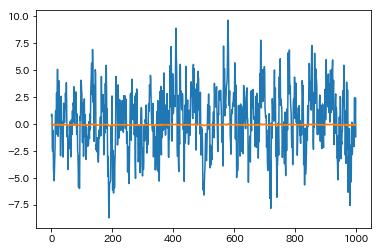

In [157]:
plt.plot(data)
plt.plot(prediction.predict(data))

In [229]:
class Prediction_inno:
        def __init__(self, model, p, param_pass=None):
            """
            modelにはインスタンスを入れる
            """
            self.predictor = model
            self.p = p
            self.predictor.load_state_dict(torch.load(param_pass)) 
        
        def predict(self, x:np.ndarray):
            ret = np.zeros_like(x)
            for i in range(x.shape[0]):
                if i>=self.p:
                    input_tensor = torch.tensor(x[i-self.p:i+1], dtype=torch.float)
                    ret[i] = self.predictor(input_tensor).item()
            return ret

In [384]:
! ls parameters/p1

No1_generator_epoch2000_batchSize64_DataSeed0.pth
No1_predictor_epoch0_batchSize64_DataSeed0.pth
No1_predictor_epoch2000_batchSize64_DataSeed0.pth


In [227]:
data.shape

(1000,)

(1000,)


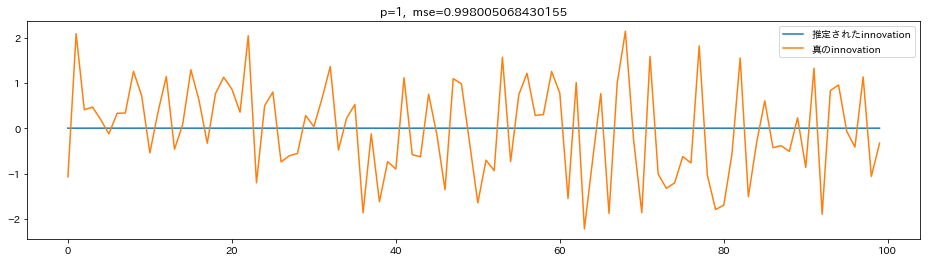

(1000,)


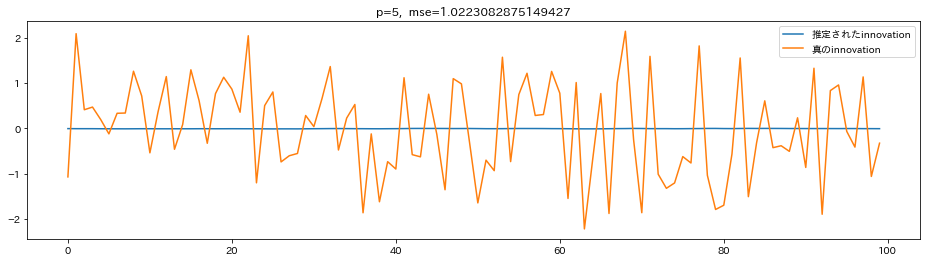

(1000,)


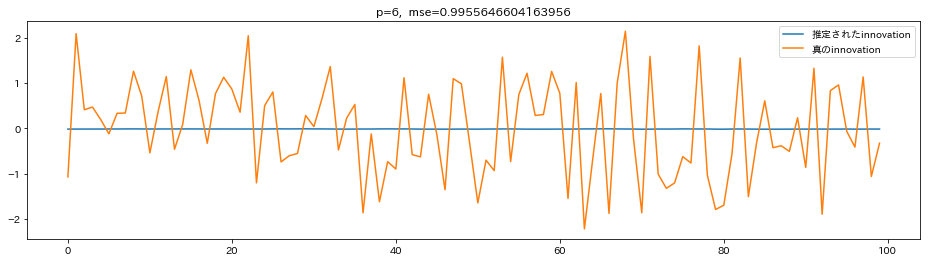

(1000,)


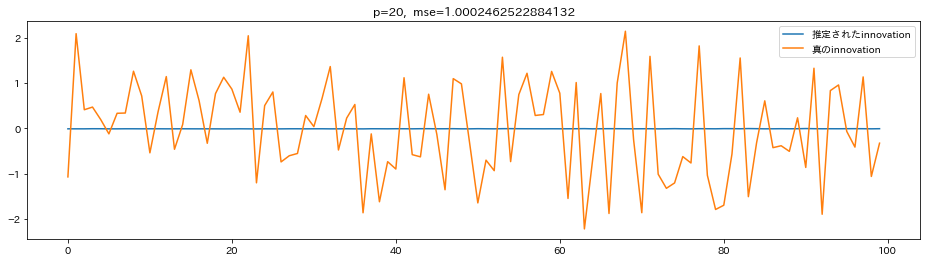

In [388]:
my_mse = []
for p in range(21):
    generator = models.FullConnectGenerator(p=p, q=0)
    if p==5:
        prediction_inno = Prediction_inno(model=generator, p=p, param_pass="parameters/p{0}/No3_generator_epoch2000_batchSize64_DataSeed0.pth".format(p))    
#     elif p==7:
#         prediction_inno = Prediction(model=generator, p=p, param_pass="parameters/p{0}/No2_generator_epoch2000_batchSize64_DataSeed0.pth".format(p))    
    elif p==1 or p==6 or p==20:
        prediction_inno = Prediction_inno(model=generator, p=p, param_pass="parameters/p{0}/No1_generator_epoch2000_batchSize64_DataSeed0.pth".format(p))    
    else:
        continue
        
    print(prediction_inno.predict(data).shape)
    my_mse.append(((inno-prediction_inno.predict(data))**2).sum()/len(data))
    plt.figure(figsize=(16,4))
    plt.plot(prediction_inno.predict(data)[-100:], label = "推定されたinnovation")
    plt.plot(inno[-100:], label='真のinnovation')
    plt.legend()
    plt.title("p={0},  mse={1}".format(p, my_mse[-1]))
    plt.savefig("/home/lab/ryuichi/Downloads/plot{0}.png".format(p))
    plt.show()

In [394]:
from statsmodels.tsa.arima_process import ar2arma

In [ ]:
ar2arma

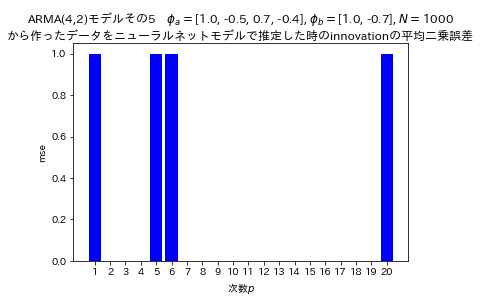

In [393]:
a = [((inno-prediction_inno.predict(data))**2).sum()/len(data)]
plt.bar([1,5,6,20],a , align="center", color=['red' if i+1==mod.ar_lags[-1] else 'blue' for i in range(20)])
plt.xticks(range(1,21))
plt.xlabel("次数$p$")
plt.ylabel('mse')
plt.title('ARMA({0},{1})モデルその{2}　'.format(p_ast,q_ast,dataSeed) + '$\phi_a=${0}, $\phi_b=${1}, $N=${2}'.format(phi_a,phi_b,N)+"\nから作ったデータをニューラルネットモデルで推定した時のinnovationの平均二乗誤差")
plt.savefig("/home/lab/ryuichi/Downloads/plot.png".format(p_ast,q_ast), bbox_inches="tight")